<a href="https://colab.research.google.com/github/damsdaddy/BDC101/blob/main/NSMC_%EA%B0%90%EC%A0%95%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step1. 라이브러리를 로드합니다.

In [7]:
!pip install chatspace

     |████████████████████████████████| 1.2MB 7.3MB/s 


In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 165kB/s 
     |████████████████████████████████| 460kB 62.5MB/s 
     |████████████████████████████████| 92kB 12.6MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [30]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re, json
from bs4 import BeautifulSoup
import urllib.request
from urllib.error import HTTPError
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm.notebook import tqdm
import chatspace
spacer = chatspace.Chatspace()

Step2. 구글 드라이브를 마운트합니다.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step3. 파일을 불러옵니다.

In [5]:
mypath = '/content/drive/MyDrive/Colab Notebooks/dataset/' # 구글 드라이브에 파일이 있는 폴더경로를 설정
train_data = pd.read_csv(mypath+'ratings_train_preprocess.csv',sep='|',index_col=0)
test_data = pd.read_csv(mypath+'ratings_test_preprocess.csv',sep='|',index_col=0)

print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print(train_data[:5]) # 상위 5개 출력
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력
print(test_data[:5])


훈련용 리뷰 개수 : 143688
         id  ...                                         correction
0   9976970  ...                                  아 더빙 진짜 짜증나네요 목소리
1   3819312  ...                   흠 포스터 보고 초딩 영화 줄 오버 연기조차 가볍지 않구나
2  10265843  ...                             너무 재밓었다 그래서 보는 것을 추천한다
3   9045019  ...                         교도소 이야기구먼 솔직히 재미는 없다 평점 조정
4   6483659  ...  사이 몬페그의 익살스런 연기가 돋보였던 영화 스파이 더 맨에서 늙어보이기만 했던 커...

[5 rows x 4 columns]
테스트용 리뷰 개수 : 48443
        id  ...                                   correction
0  6270596  ...                                          굳 ㅋ
2  8544678  ...           뭐야 이 평점들은 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
3  6825595  ...                   지루하지는 않은데 완전 막장임 돈 주고 보기에는
4  6723715  ...  3만 아니었어도 별 다섯 개 줬을텐데 왜 3로 나와서 제 심기를 불편하게 하죠
5  7898805  ...                           음악이 주가 된 최고의 음악 영화

[5 rows x 4 columns]


Step6. 띄어쓰기 검사를 실행합니다.
- (주피터 환경) 네이버의 맞춤법 검사 API 호출방식을 이용합니다.
- (코랩 환경) chatspace 띄어쓰기 검사방식을 이용합니다.

In [6]:
# 맞춤법 검사
def correct_sentence(s):
    # API 파라메터 설정
    params = urllib.parse.urlencode({ 
        "_callback": "", 
        "q": s 
    })

    try:
      # 네이버 맞춤법 검사 API 호출
      #data = urllib.request.urlopen("https://m.search.naver.com/p/csearch/ocontent/spellchecker.nhn?" + params) #책의 url을 바꿈
      #data = data.read().decode("utf-8")[1:-2]
      #data = json.loads(data)
      #data = data["message"]["result"]["html"]
      #data = soup = BeautifulSoup(data, "html.parser").getText()
      # 리턴
      data = spacer.space(s) # 구글 코랩에서는 띄어쓰기 교정 chatspace 로 대체실행
      return data
    except HTTPError as e: # 호출 에러 시에는 입력값 그대로 반환
      return s

Step7. 불용어 설정

In [9]:
stopwords = [
             '의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다',
             '을','이다','다','로','그'
]

print(stopwords)

['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다', '을', '이다', '다', '로', '그']


Step8. 형태소 분석기 설정

In [10]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

Step9. 형태소 분석

In [11]:
X_train = []
for sentence in tqdm(train_data['correction']):
    temp_X = []
    temp_X = okt.morphs(sentence, norm=True, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

print(X_train[:30])


[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너무', '재밓었다', '그래서', '보다', '것', '추천'], ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'], ['사이', '몬페그', '익살스럽다', '연기', '돋보이다', '영화', '스파이', '더', '맨', '에서', '늙다', '보이다', '커스틴', '던스트', '너무', '나다', '이쁘다', '보이다'], ['막', '걸음', '마', '떼다', '3', '세', '부터', '초등학교', '1', '학년', '생인', '8', '살', '용', '영화', 'ㅋㅋ', '별', '반개', '아깝다', '움'], ['원작', '긴장감', '제대로', '살리다', '못'], ['별', '반개', '아깝다', '욕', '나오다', '이응경', '길용우', '연기', '생활', '몇', '년', '인지', '정말', '발', '해도', '그것', '보단', '낫다', '납치', '감금', '만', '반복', '반복', '드라마', '가족', '없다', '연기', '못', '사람', '만', '모', '엿', '네'], ['액션', '없다', '재미', '있다', '몇', '안', '되다', '영화'], ['왜', '이렇게', '평점', '낮다', '거', '인데', '꽤', '볼', '만', '데', '헐다', '리', '우드', '식', '화려하다', '너무', '길들이다', '있다'], ['인피니트', '짱', '진짜', '짱'], ['볼', '때', '마다', '눈물', '나서다', '죽다', '90년', '대의', '향수', '극', '허진호', '감성', '절제', '멜로', '달인'], ['울면', '서', '손', '고', '횡단보도', '건너다', '때', '뛰다', '치다', '나오다', '뻔', 

In [12]:
X_test = []
for sentence in tqdm(test_data['correction']):
    temp_X = []
    temp_X = okt.morphs(sentence, norm=True, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

print(X_test[:30])


[['굳다', 'ㅋ'], ['뭐', '야', '평점', '나쁘다', '않다', '10', '점', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는'], ['3만', '아니다', '별', '다섯', '개', '주다', '왜', '3', '나오다', '제', '심기', '불편하다'], ['음악', '주가', '되다', '최고', '음악', '영화'], ['진정하다', '쓰레기'], ['마치', '미국', '애니', '에서', '튀어나오다', '창의력', '없다', '로봇', '디자인', '부터', '가다', '고개', '젖다'], ['갈수록', '개판', '되다', '중국영화', '유치하다', '내용', '없다', '폼', '잡다', '끝나다', '말', '안', '되다', '무기', '유치하다', '남무', '아', '그리다', '동사서독', '같다', '영화', '것', '3', '류', '아', '류작'], ['이별', '아픔', '뒤', '찾아오다', '새롭다', '인연', '기쁨', '모든', '사람', '그렇다', '않다'], ['괜찮다', '오랜만', '포켓몬스터', '잼밌어', '요'], ['한국', '독립', '영화', '한계', '그렇게', '아버지', '되다', '오다', '비교', '되다'], ['청춘', '아름답다', '아름답다', '움', '이성', '흔들다', '놓다', '찰나', '아름답다', '움', '자다', '포착', '섬세하다', '아름답다', '수채화', '같다', '퀴어', '영화'], ['눈', '보이다', '반전', '영화', '흡인', '력', '사라지다', '않다'], ['스토리', '연출', '연기', '비주', '얼', '등', '영화', '기본', '조차', '안', '되다', '영화', '무슨', '평', '해', '이렇다', '영화', '찍다', '김문옥', '감독', '내', '영화', '경력', '몇', 

Step10. 단어집 조회

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '없다': 3, '있다': 4, '것': 5, '좋다': 6, '너무': 7, '되다': 8, '재밌다': 9, '정말': 10, '안': 11, '거': 12, '만': 13, 'ㅋㅋ': 14, '적': 15, '같다': 16, '진짜': 17, '점': 18, '아니다': 19, '않다': 20, '게': 21, '나': 22, '에서': 23, '만들다': 24, '나오다': 25, '보고': 26, '연기': 27, '이렇다': 28, '수': 29, '평점': 30, '내': 31, '못': 32, '인': 33, '왜': 34, '자다': 35, '최고': 36, '더': 37, '말': 38, '스토리': 39, '생각': 40, '드라마': 41, '아': 42, '싶다': 43, '때': 44, '사람': 45, '감동': 46, '1': 47, '배우': 48, '고': 49, '아깝다': 50, '볼': 51, '내용': 52, '감독': 53, '뭐': 54, '주다': 55, '그냥': 56, '중': 57, '재미있다': 58, '까지': 59, '재미': 60, '요': 61, '가다': 62, '그렇다': 63, '들다': 64, '오다': 65, '하고': 66, '시간': 67, '지루하다': 68, '재미없다': 69, '쓰레기': 70, '듯': 71, '하나': 72, '모르다': 73, '걸': 74, '네': 75, 'ㅠㅠ': 76, '사랑': 77, '줄': 78, '작품': 79, '다시': 80, '10': 81, '나다': 82, '마지막': 83, '저': 84, '액션': 85, '알다': 86, '정도': 87, '이렇게': 88, '인데': 89, '처음': 90, '지': 91, 'ㅋ': 92, '완전': 93, '많다': 94, '차다': 95, '건': 96, '장면': 97, '난': 98, '주인공': 99, '개': 100, '2': 101, '지금': 102,

Step11. 희귀단어 임계치 이하인 경우 제외시켜서 단어집 최적화

In [14]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40633
등장 빈도가 2번 이하인 희귀 단어의 수: 22137
단어 집합에서 희귀 단어의 비율: 54.48034848522138
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.6903683813929475


In [15]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 18498


Step12. 단어를 인덱스로 변환한다.

In [16]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train[:3])

[[43, 529, 18, 241, 686], [763, 455, 27, 628, 2, 79, 1444, 28, 899, 700, 21], [8, 1, 553, 3, 6, 225]]


Step13. 결과값 저장

In [17]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

Step14. 빈 샘플을 제거한다.

In [18]:
# 빈 샘플들을 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

143680
143680


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Step15. 문장의 길이 분포분석

리뷰의 최대 길이 : 70
리뷰의 평균 길이 : 11.296067650334075


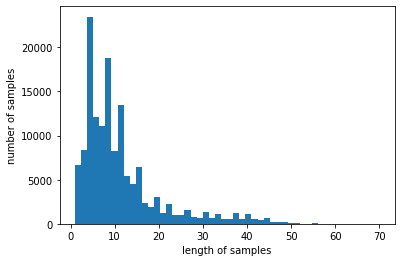

In [19]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Step16. 문장의 최대길이 설정

In [20]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [21]:
max_len = 45
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 45 이하인 샘플의 비율: 99.38056792873051


Step17. 최대길이에 맞춰 패딩

In [22]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

Step18. 라이브러리 로드

In [23]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Step19. 모델 생성

In [24]:
model = Sequential()
model.add(Embedding(vocab_size, 128))
model.add(LSTM(128, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

Step20. 검증손실값이 4회 연속 증가 시 earlystop, 검증정확도가 최대인 경우에만 모델저장

In [25]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

Step21. 모델을 훈련한다.

In [26]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=30, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/30
1916/1916 [==============================] - 34s 13ms/step - loss: 0.4385 - acc: 0.7940 - val_loss: 0.3470 - val_acc: 0.8470

Epoch 00001: val_acc improved from -inf to 0.84695, saving model to best_model.h5
Epoch 2/30
1916/1916 [==============================] - 23s 12ms/step - loss: 0.3260 - acc: 0.8592 - val_loss: 0.3321 - val_acc: 0.8549

Epoch 00002: val_acc improved from 0.84695 to 0.85485, saving model to best_model.h5
Epoch 3/30
1916/1916 [==============================] - 23s 12ms/step - loss: 0.3028 - acc: 0.8715 - val_loss: 0.3219 - val_acc: 0.8603

Epoch 00003: val_acc improved from 0.85485 to 0.86035, saving model to best_model.h5
Epoch 4/30
1916/1916 [==============================] - 23s 12ms/step - loss: 0.2813 - acc: 0.8838 - val_loss: 0.3216 - val_acc: 0.8612

Epoch 00004: val_acc improved from 0.86035 to 0.86118, saving model to best_model.h5
Epoch 5/30
1916/1916 [==============================] - 22s 12ms/step - loss: 0.2685 - acc: 0.8886 - val_loss: 0.32

Step22. 테스트 데이터셋으로 정확도 측정

In [27]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1514/1514 [==============================] - 5s 3ms/step - loss: 0.3317 - acc: 0.8644

 테스트 정확도: 0.8644


Step23. 예측함수 생성

In [36]:
# 휴리스틱 검출규칙 : 비표준어에 대해 직관적인 방법으로 규칙을 만들어 교체
heuristic_rule = [
    ['ㅋㅋ+', ' ㅋㅋ '],
    ['ㄹㄹ+', ' ㄹㄹ '],
    ['ㅜㅜ+', ' ㅜㅜ '],
    ['ㅠㅠ+', ' ㅠㅠ '],
    ['ㄷㄷ+', ' ㄷㄷ '],
    ['ㅎㅎ+', ' ㅎㅎ '],
    ['ㅡㅡ+', ' ㅡㅡ '],
    ['^ +', ''],    
    ['  +', ' ']
]

def sentiment_predict(new_sentence):
  #new_sentence = correct_sentence(new_sentence)
  new_sentence = new_sentence.replace("[^0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 숫자한글공백제외한 문자제거
  for rule in heuristic_rule:
    new_sentence = new_sentence.replace(rule[0],rule[1]) # 휴리스틱 규칙적용
  
  new_sentence = okt.morphs(new_sentence, norm=True, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    return 1 # 긍정값
  else:
    return 0 # 부정값

In [31]:
sentiment_predict('보시면 별로임을 알 수 있습니다') # 테스트

0

Step24. 시험 데이터셋 로드

In [32]:
real_data = pd.read_csv(mypath+'ko_data_utf8.csv')
real_data['Predicted'] = 0

In [33]:
real_data.head()

,Id,Sentence,Predicted
0,0,정말 많이 울었던 영화입니다.,0
1,1,시간 낭비예요.,0
2,2,포스터를 저렇게밖에 만들지 못했던 제작자의 소심함에 침을 뱉고 싶다.,0
3,3,지금 봐도 재미있는 영화!!! 코믹과 감동!!! 그리고 요리!!!,0
4,4,이걸 영화로 만드는 거야?얼마나 가는지 보자.,0


Step25. 예측실행

In [37]:
for i in tqdm(real_data.index):
  real_data['Predicted'][i] = sentiment_predict(real_data['Sentence'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
real_data[:30]

,Id,Sentence,Predicted
0,0,정말 많이 울었던 영화입니다.,1
1,1,시간 낭비예요.,0
2,2,포스터를 저렇게밖에 만들지 못했던 제작자의 소심함에 침을 뱉고 싶다.,0
3,3,지금 봐도 재미있는 영화!!! 코믹과 감동!!! 그리고 요리!!!,1
4,4,이걸 영화로 만드는 거야?얼마나 가는지 보자.,0
5,5,잔잔한 감동을 주는 영화가 좋은 영화다. 줄리안 무어의 매력!,1
6,6,"프랑스 영화, 정말 재미없다는 말밖에...",0
7,7,이보다 더 자연스러울 수는 없다.,1
8,8,잠만 자고 있었는데~~,0
9,9,오프닝 씬이... (이 영화와 젊음에 대해 말한다.),1


Step26. 결과 저장

In [ ]:
real_data.to_csv(mypath+'ko_sample.csv',columns=['Id','Predicted'],index=False)
#real_data.to_csv('sample_full.csv',columns=['Id','Sentence','Predicted'],index=False)
#pd.DataFrame(tokenizer.word_counts.items()).to_csv('word_counts.csv',index=False)